In [1]:
# Helper function, used these for debugging purposes
# detector2 build only succeeds if CUDA version is correct

!nvidia-smi
!nvcc --version

import torch
torch.__version__
import torchvision
torchvision.__version__

#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Thu Feb 20 03:16:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Base setup:
# detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
import os
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

# Define the dataset paths
TRAIN_PATH = '/kaggle/input/solarpv-dataset/train'
TEST_PATH = '/kaggle/input/solarpv-dataset/test'
VALID_PATH = '/kaggle/input/solarpv-dataset/valid'

def get_solar_panel_dicts(dataset_dict):
    """
    Convert processed dataset to Detectron2 format
    """
    detectron2_annotations = []
    
    for image in dataset_dict['images']:
        record = {}
        
        # Get image info
        record["file_name"] = image['file_name']
        record["height"] = image['height']
        record["width"] = image['width']
        record["image_id"] = image['id']
        
        # Get annotations for this image
        annos = []
        for anno in dataset_dict['annotations']:
            if anno['image_id'] == image['id']:
                obj = {
                    "bbox": anno['bbox'],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": anno['segmentation'],
                    "category_id": anno['category_id'],
                    "iscrowd": anno.get('iscrowd', 0)
                }
                annos.append(obj)
        
        record["annotations"] = annos
        detectron2_annotations.append(record)
    
    return detectron2_annotations

def process_dataset(annotations, images_path):
    dataset = {
        'images': [],
        'annotations': annotations['annotations'],
        'categories': annotations['categories']
    }
    
    for img in annotations['images']:
        img['file_name'] = os.path.join(images_path, img['file_name'])
        dataset['images'].append(img)
    
    return dataset

# Load and process the datasets
train_annotations = json.load(open(os.path.join(TRAIN_PATH, '_annotations.coco.json')))
test_annotations = json.load(open(os.path.join(TEST_PATH, '_annotations.coco.json')))
valid_annotations = json.load(open(os.path.join(VALID_PATH, '_annotations.coco.json')))

train_dataset = process_dataset(train_annotations, TRAIN_PATH)
test_dataset = process_dataset(test_annotations, TEST_PATH)
valid_dataset = process_dataset(valid_annotations, VALID_PATH)

# Register the datasets with Detectron2
def register_datasets():
    """
    Register all splits with Detectron2
    """
    # Get category names from annotations
    categories = {cat['id']: cat['name'] for cat in train_annotations['categories']}
    thing_classes = list(categories.values())
    
    # Register each split
    splits = {
        'train': train_dataset,
        'test': test_dataset,
        'valid': valid_dataset
    }
    
    for split_name, dataset in splits.items():
        name = f"solar_panel_{split_name}"
        DatasetCatalog.register(
            name,
            lambda d=dataset: get_solar_panel_dicts(d)
        )
        MetadataCatalog.get(name).set(
            thing_classes=thing_classes
        )

# Register the datasets
register_datasets()

# Verify registration
for split in ['train', 'test', 'valid']:
    dataset_name = f"solar_panel_{split}"
    print(f"Registered {dataset_name}")

Registered solar_panel_train
Registered solar_panel_test
Registered solar_panel_valid


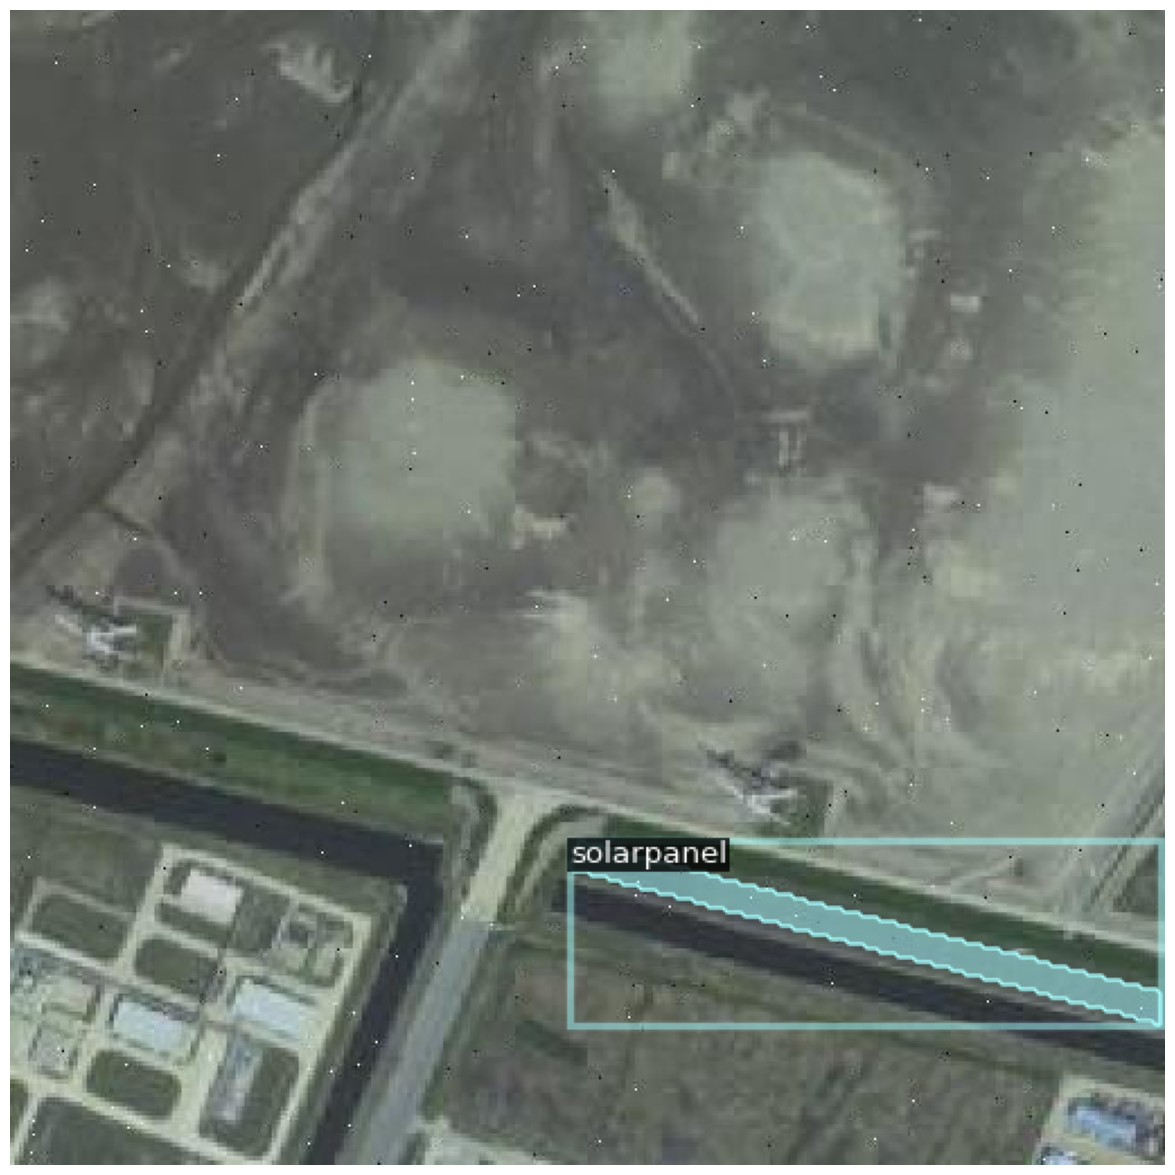

Image 1:
Number of annotations: 1
Image dimensions: (640, 640, 3)
--------------------------------------------------


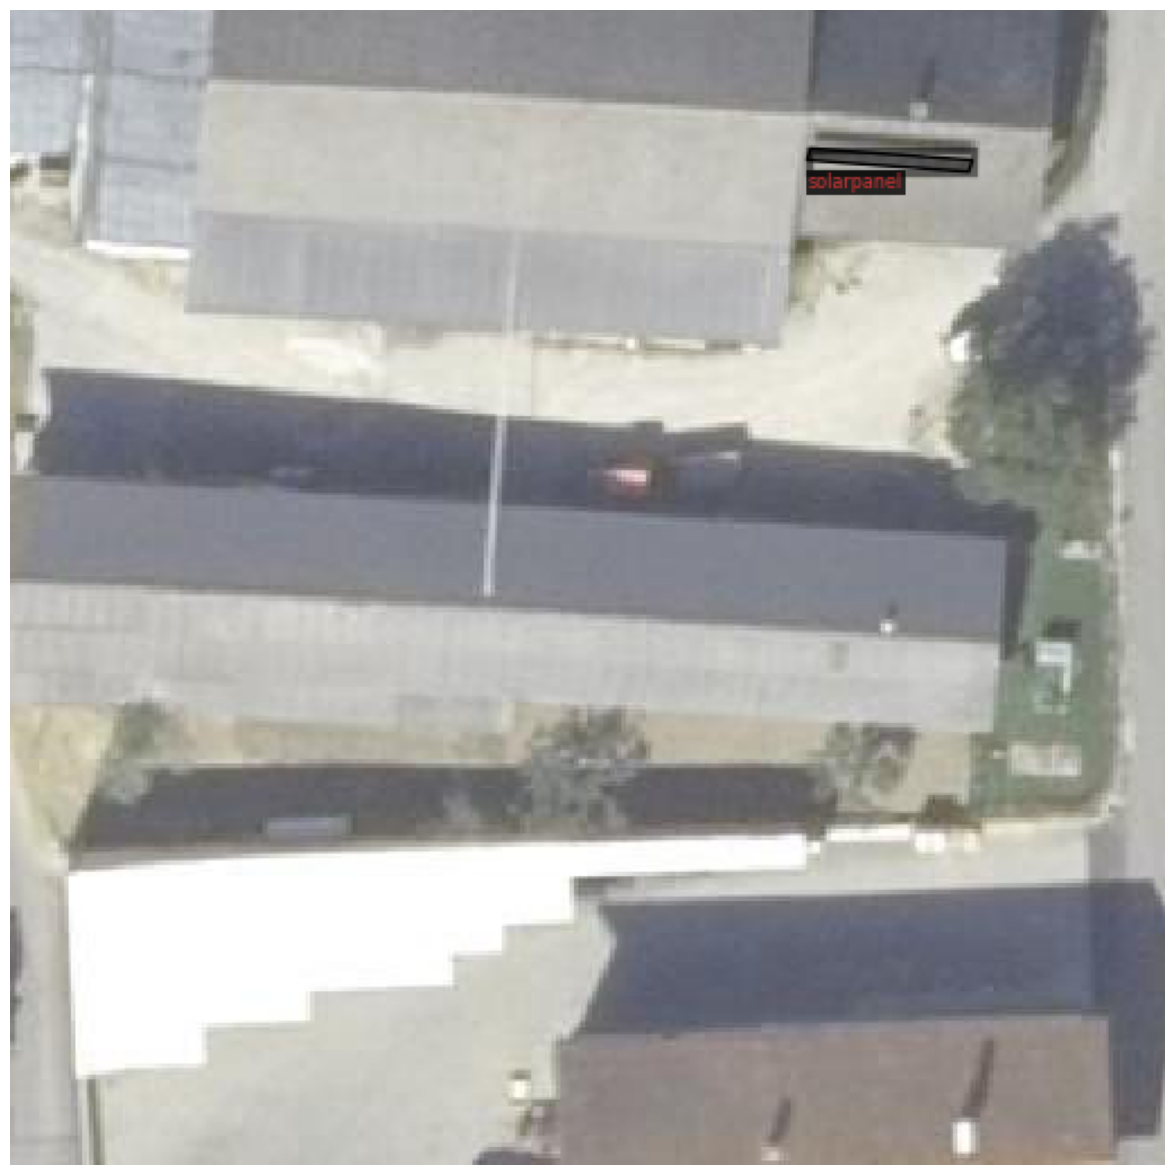

Image 2:
Number of annotations: 1
Image dimensions: (640, 640, 3)
--------------------------------------------------


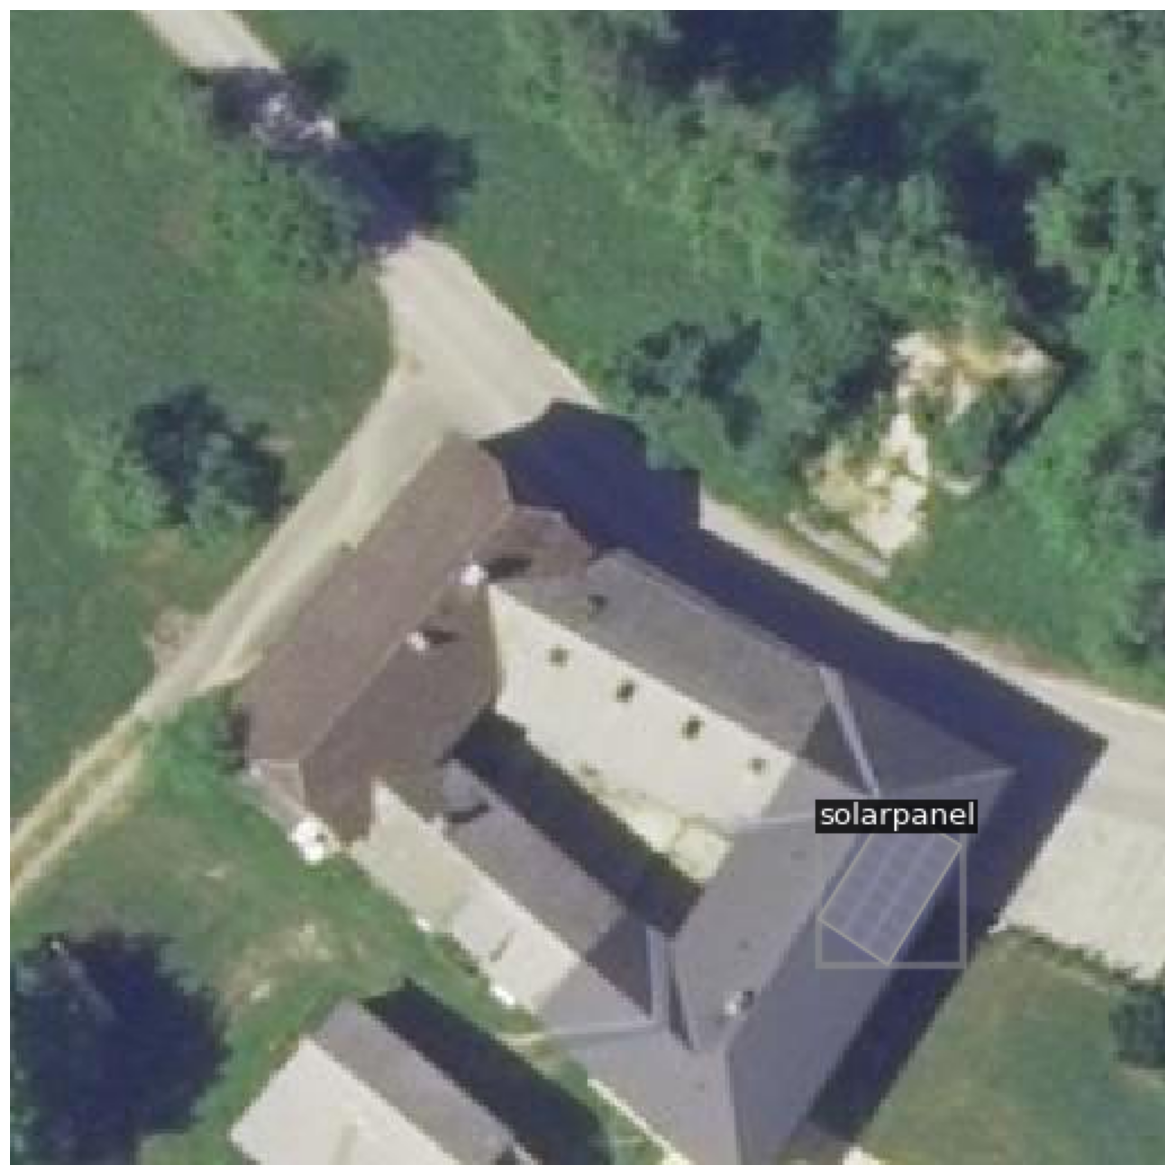

Image 3:
Number of annotations: 1
Image dimensions: (640, 640, 3)
--------------------------------------------------


In [4]:
from datetime import datetime
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
import cv2

def show_image(image, figsize=(15,15)):
    """
    Display image in Kaggle notebook environment
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define the dataset name correctly
TRAIN_DATA_SET_NAME = "solar_panel_train"  # This should match what we registered earlier

# Get metadata and dataset
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

# Visualize a few training images
num_samples = 3  # Change this to view more or fewer images

for i, dataset_entry in enumerate(dataset_train[:num_samples]):
    # Read the image
    image = cv2.imread(dataset_entry["file_name"])
    if image is None:
        print(f"Failed to load image: {dataset_entry['file_name']}")
        continue
        
    # Create visualizer instance
    visualizer = Visualizer(
        image[:, :, ::-1],  # BGR to RGB
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    
    # Draw the annotations
    out = visualizer.draw_dataset_dict(dataset_entry)
    
    # Display the image with annotations
    show_image(out.get_image())
    
    # Print some information about the annotations
    print(f"Image {i+1}:")
    print(f"Number of annotations: {len(dataset_entry['annotations'])}")
    print(f"Image dimensions: {image.shape}")
    print("-" * 50)

In [6]:
from detectron2.engine import DefaultTrainer

# Create a configuration object
cfg = get_cfg()

# Change to Mask R-CNN configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the training dataset
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
# No test dataset
cfg.DATASETS.TEST = ()

# Number of data loading workers
cfg.DATALOADER.NUM_WORKERS = 2

# Initialize the model weights from Mask R-CNN model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Training hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 20000

# ROI heads configuration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# Mask R-CNN specific configurations
cfg.MODEL.MASK_ON = True  # Enable mask head
cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 14  # Mask resolution
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV = 4  # Number of conv layers in the mask head
cfg.MODEL.ROI_MASK_HEAD.CONV_DIM = 256  # Dimension of mask conv layers

# Create the output directory if it doesn't exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create a trainer with the specified configuration
trainer = DefaultTrainer(cfg)

# Resume training if a checkpoint exists, or start from scratch
trainer.resume_or_load(resume=True)

# Start training
trainer.train()

[02/20 03:21:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 244MB/s]                             


[02/20 03:22:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/20 03:22:47 d2.utils.events]:  eta: 0:02:24  iter: 19  total_loss: 2.425  loss_cls: 1.164  loss_box_reg: 0.238  loss_mask: 0.6912  loss_rpn_cls: 0.261  loss_rpn_loc: 0.03258    time: 0.3804  last_time: 0.3542  data_time: 0.0177  last_data_time: 0.0100   lr: 4.8453e-05  max_mem: 3095M
[02/20 03:23:07 d2.utils.events]:  eta: 0:02:19  iter: 39  total_loss: 1.95  loss_cls: 0.5923  loss_box_reg: 0.3666  loss_mask: 0.6577  loss_rpn_cls: 0.2653  loss_rpn_loc: 0.04691    time: 0.3830  last_time: 0.3921  data_time: 0.0108  last_data_time: 0.0117   lr: 9.8403e-05  max_mem: 3095M
[02/20 03:23:15 d2.utils.events]:  eta: 0:02:10  iter: 59  total_loss: 1.608  loss_cls: 0.3825  loss_box_reg: 0.3361  loss_mask: 0.578  loss_rpn_cls: 0.1558  loss_rpn_loc: 0.05216    time: 0.3812  last_time: 0.3897  data_time: 0.0112  last_data_time: 0.0136   lr: 0.00014835  max_mem: 3095M
[02/20 03:23:22 d2.utils.events]:  eta: 0:02:02  iter: 79  total_loss: 1.496  loss_cls: 0.3557  loss_box_reg: 0.4652  loss_mask: 

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/20 03:25:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

 /kaggle/input/solarpv-dataset/test/006_jpg.rf.bdffe8a9719e3b18a979daecbd1d2ede.jpg


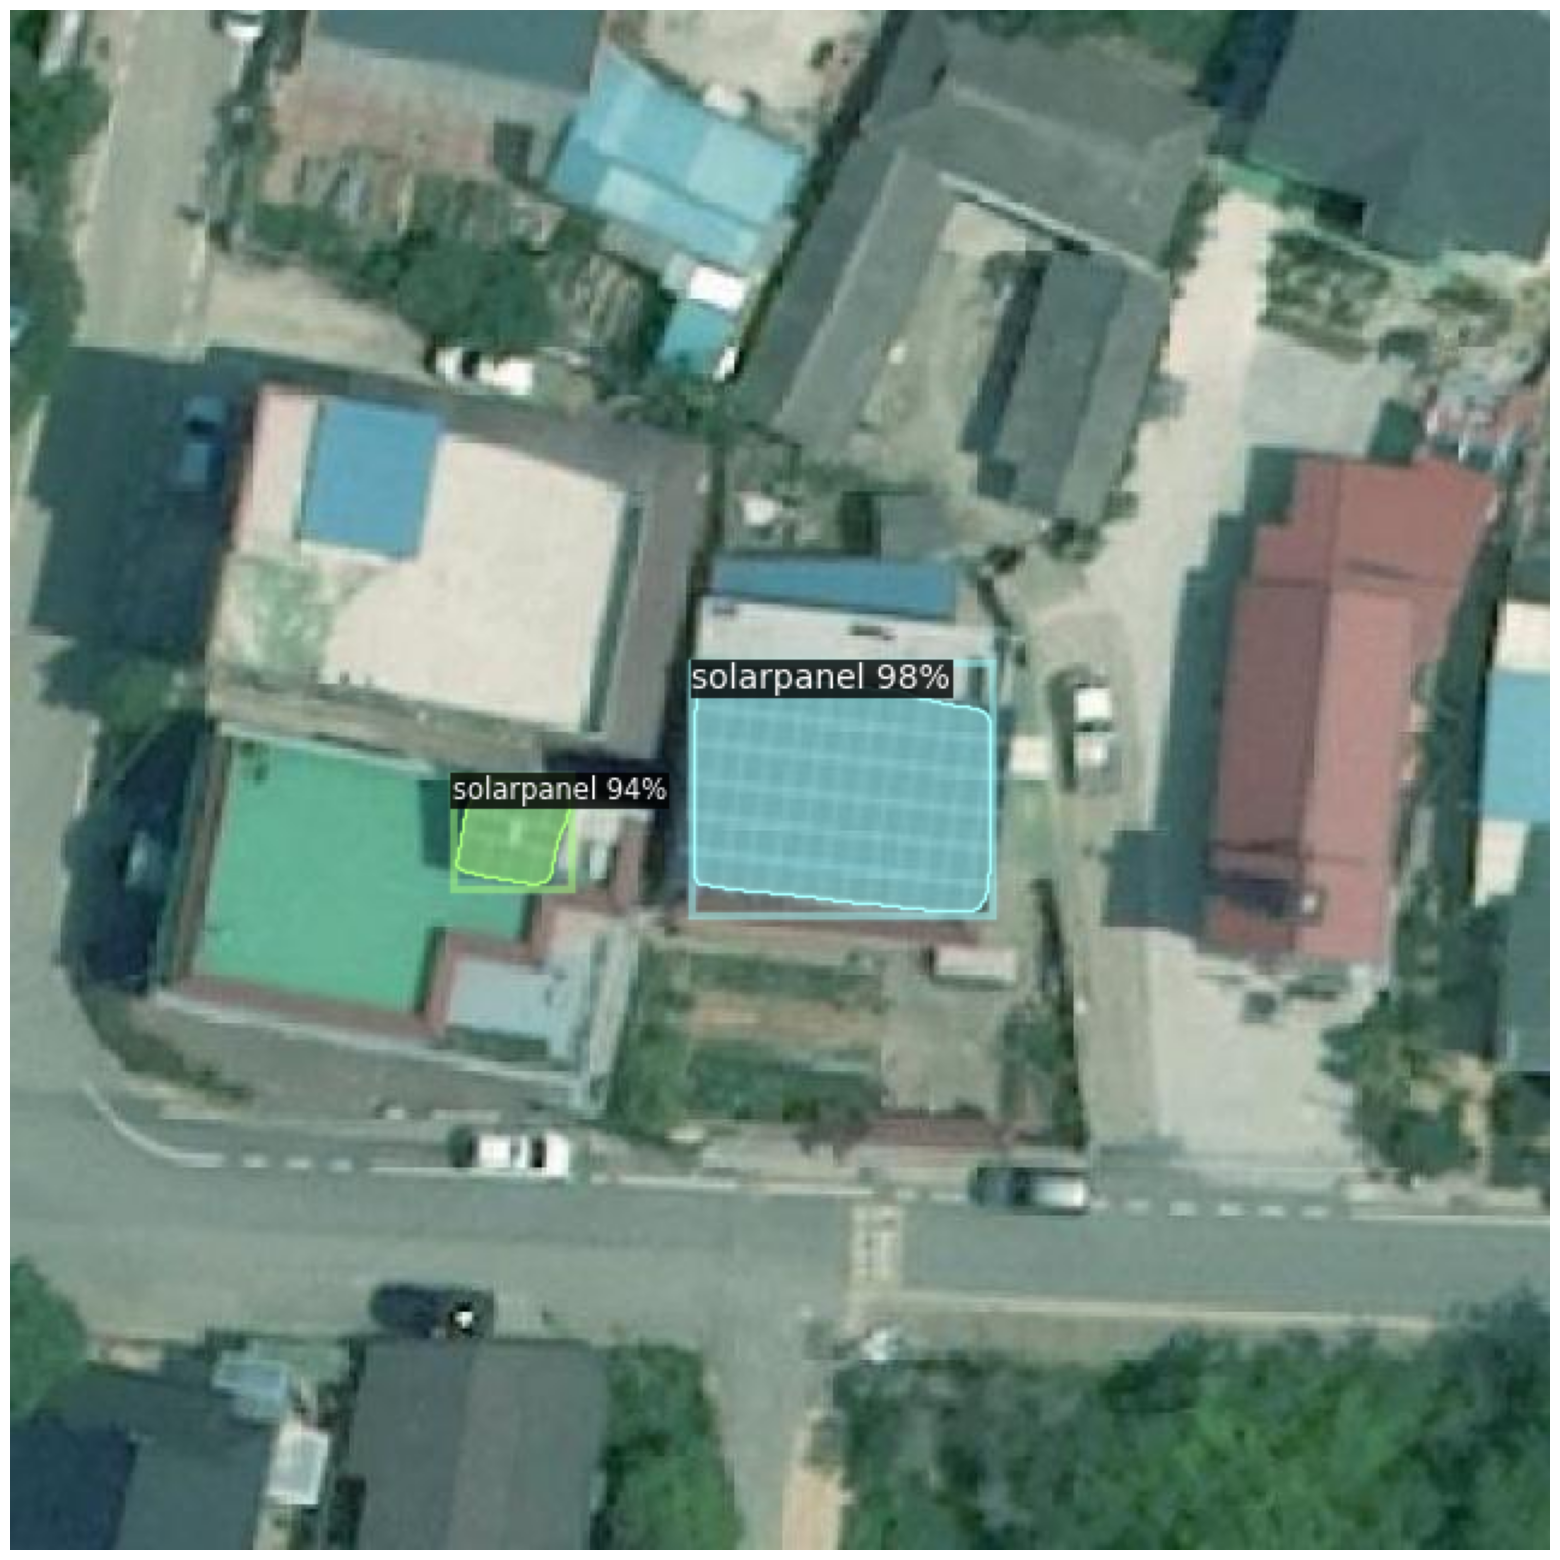

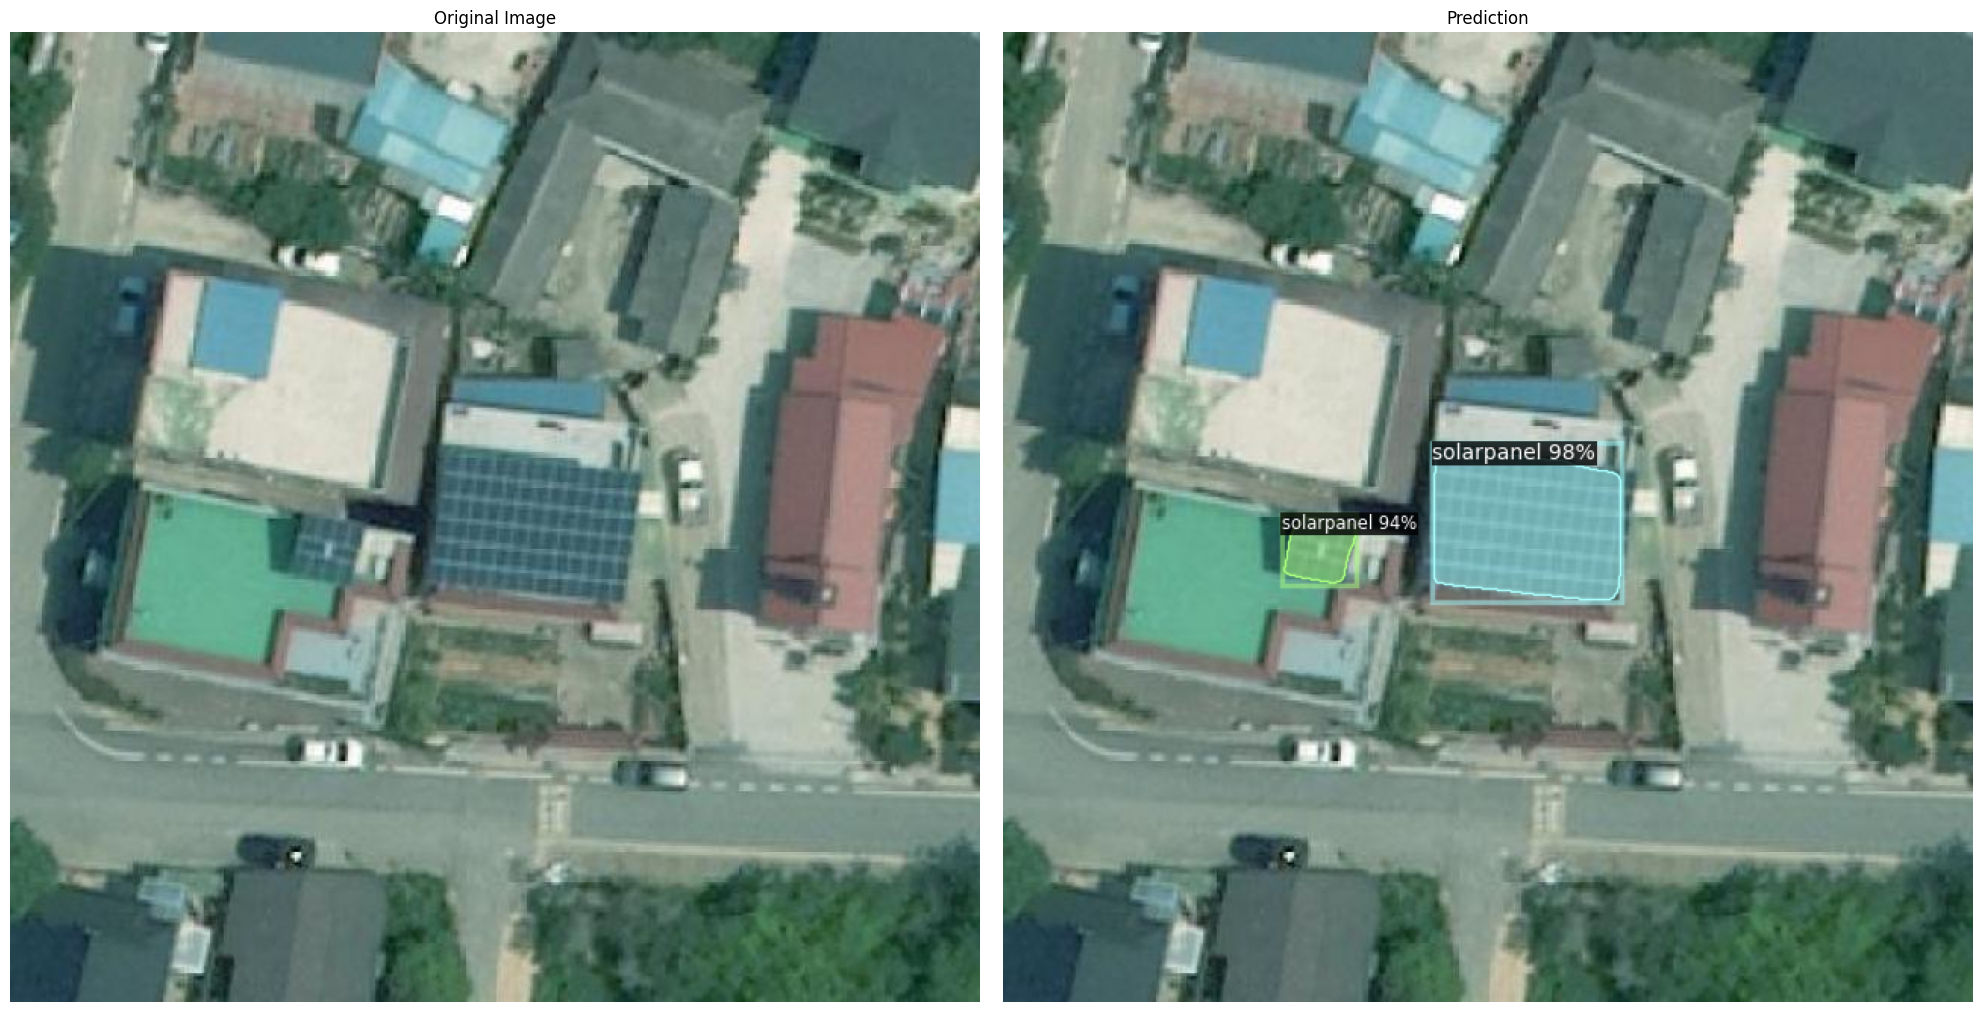

In [8]:
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

def show_prediction(image, figsize=(20,20)):
    """
    Display prediction visualization in Kaggle notebook
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Get metadata
train_metadata = MetadataCatalog.get("solar_panel_train")

# For Kaggle, you might want to use a file path instead of input()
# Example: new_im = cv2.imread("path/to/test/image.jpg")
new_im = cv2.imread(input())
outputs = predictor(new_im)

# Create visualizer and draw predictions
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Replace cv2_imshow with matplotlib display
show_prediction(out.get_image())

# If you want to show input and prediction side by side:
def show_input_and_prediction(original_image, prediction_image, figsize=(20,10)):
    """
    Display original image and prediction side by side
    """
    plt.figure(figsize=figsize)
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(prediction_image)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Use it like this:
show_input_and_prediction(new_im, out.get_image())

## Download the Trained Model
The trained model is saved in the `/kaggle/working/output/` directory. download the model_final.pth


In [9]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

## Download the Configuration File
The configuration file `config.yml` is saved in the `/kaggle/working/` directory.


## Save Model and Configuration for Inference  
Move the model and config.yaml to the same directory. This will make it easier to upload and use them for inference later.